# Explore here

It's recommended to use this notebook for exploration purposes.

Data cleaned and stored in spotify_data.db


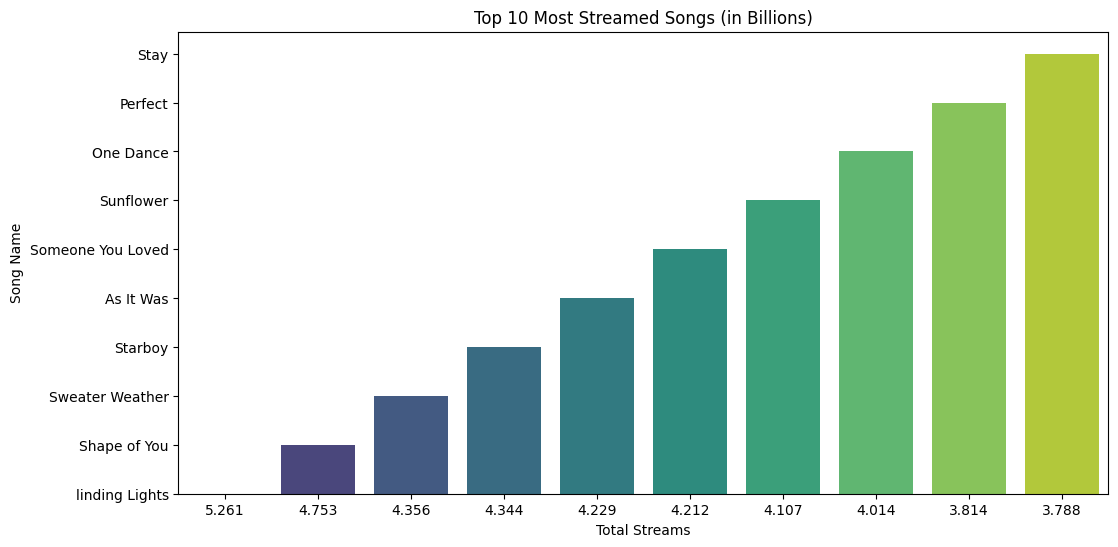

In [2]:
import os
import re
import pandas as pd
from bs4 import BeautifulSoup
import requests
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Fetch the webpage content
url = "https://en.wikipedia.org/wiki/List_of_Spotify_streaming_records"
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36'
}

response = requests.get(url, headers=headers)
response.raise_for_status() 

# 2. Parse the HTML and find the table
soup = BeautifulSoup(response.content, 'html.parser')
table = soup.find("table", class_="wikitable")

if table:
    data = []
    # Get headers
    headers_row = table.find_all("tr")[0]
    column_names = [th.text.strip() for th in headers_row.find_all("th")]

    # Get rows
    for row in table.find_all("tr")[1:26]:
        cells = row.find_all(["td", "th"])
        data.append([cell.text.strip() for cell in cells])

    # 3. Create DataFrame
    df = pd.DataFrame(data, columns=column_names)

    # 4. Cleaning Function
    def clean_value(val):
        if val is None: return None
        # Remove anything that isn't a digit, a decimal point, or a letter/space
        # This specifically strips out $, B, commas, and [ref] tags
        cleaned = re.sub(r'[^\d\.\w\s]', '', str(val))
        cleaned = cleaned.replace('B', '').strip()
        return cleaned if cleaned != "" else None

    # Apply cleaning to all cells using .map()
    df = df.map(clean_value)

    # Drop rows missing crucial info
    df = df.dropna(subset=[df.columns[1], df.columns[3]])


    # Drop rows where numeric conversion failed
    df = df.dropna(subset=[df.columns[3]])

    # 5. Store in SQLite
    conn = sqlite3.connect('spotify_data.db')
    df.to_sql('popular_songs', conn, if_exists='replace', index=False)
    conn.commit()
    print("Data cleaned and stored in spotify_data.db")

    # 6. Visualize
    plt.figure(figsize=(12, 6))
    # Using column indices to ensure we hit 'Streams' and 'Song' regardless of exact header text
    sns.barplot(
        data=df.head(10), 
        x=df.columns[3], 
        y=df.columns[1], 
        hue=df.columns[1], 
        palette='viridis', 
        legend=False
    )
    plt.gca().invert_yaxis()
    
    plt.title('Top 10 Most Streamed Songs (in Billions)')
    plt.xlabel('Total Streams')
    plt.ylabel('Song Name')
    plt.show()

    conn.close()
else:
    print("Could not find the table on the page.")